In [173]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Data Preparation

In [174]:
data = pd.read_csv('data/dataset.csv')
data.sample(5)

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
3800,1.237650e+18,136.533874,55.958157,16.43054,15.19474,15.22174,15.30752,15.39518,1345,301,5,197,5.067690e+17,STAR,0.000129,450,51908,415
8250,1.237650e+18,182.557987,-0.436585,18.95998,17.17553,16.26040,15.83789,15.53196,756,301,2,446,3.220270e+17,GALAXY,0.082155,286,51999,73
8307,1.237650e+18,193.440830,-1.772791,18.82772,17.50249,16.66699,16.26188,15.97142,1140,301,5,271,3.806500e+17,GALAXY,0.120496,338,51694,348
9604,1.237650e+18,170.660576,1.059819,18.68817,17.20295,16.30880,15.84517,15.49629,756,301,6,366,3.153750e+17,GALAXY,0.075649,280,51612,448
845,1.237650e+18,237.777183,-0.195781,19.23882,17.96441,18.02486,18.13573,18.22423,745,301,3,528,3.862670e+17,STAR,0.000533,343,51692,303


## 1. Representation

a) Deal with missing values <br>
b) Decide on inputs and outputs <br>
c) Remove obviously irrelevant inputs <br>
d) Encode non-numeric values

#### a) Deal with missing values

In [175]:
sum(data.isnull().values.ravel())

0

- There are no missing values

#### b) Decide on inputs and outputs

Our dataset is basically made up of 4 sections:
1. Position of Object
2. Magnitude of object
3. Image Metadata
4. Spectral Readings

Since our NN's will be used to predict *astronomical objects* based on recorded *physical* observations, section 3 is not needed, but as positions of objects could be an indicator of what they are in the context of relativity to another celestial body. For example, an object's likelihood of being a planet goes up if it is orbiting a star. As such, the fields ra, dec, u, g, r, i, z from the Object position and Thaum-Guan magnitude system as well as the redshift from the Spectral Readings will be used to determine the object class, which is a discrete set which consists of Galaxy, Quasar and Star.

#### c) Remove obviously irrelevant inputs

In [176]:
data = pd.DataFrame({
	x: data[x] for x in ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'redshift', 'class']
})
data.head()

,ra,dec,u,g,r,i,z,redshift,class
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,-0.000009,STAR
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,-0.000055,STAR
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,0.123111,GALAXY
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,-0.000111,STAR
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,0.000590,STAR


## Data Encoding

The output column 'class' is a discrete set which consists of Galaxy, Quasar and Star. For this I will be using [Binary One-Hot Encoding]().


In [177]:
cleaned_data = pd.get_dummies(data, columns=['class'])
cleaned_data.head()

,ra,dec,u,g,r,i,z,redshift,class_GALAXY,class_QSO,class_STAR
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,-0.000009,0,0,1
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,-0.000055,0,0,1
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,0.123111,1,0,0
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,-0.000111,0,0,1
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,0.000590,0,0,1


## 2. Scaling and normalization

Looking at the distribution graph of the dataset:

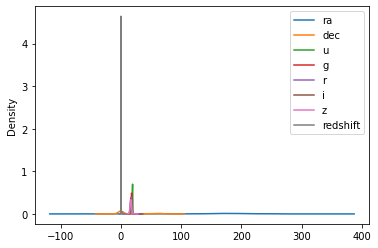

In [178]:
ax = cleaned_data.drop(columns=[x for x in cleaned_data if 'class' in x]).plot.density()

We see that the ranges between the columns are significantly different, therefore, using mean normalization with the formula:
$
Z^{MV}_{i,p} = \frac{Z_{i,p}-\bar{Z_i}}{\sigma_{Z_i}}
$

In [179]:
def z_score_normalize(df:pd.DataFrame):
	return (df-df.mean())/df.std()

def replace_cols(df1, df2, columns):
	for x in columns:
		df1[x] = df2[x]
	return df1

scaled_data = replace_cols(z_score_normalize(cleaned_data), cleaned_data, [x for x in cleaned_data if "class" in x])
scaled_data.head()

,ra,dec,u,g,r,i,z,redshift,class_GALAXY,class_QSO,class_STAR
0,0.167450,-0.584893,1.031435,-0.348542,-0.837238,-0.946010,-0.995292,-0.369713,0,0,1
1,0.168853,-0.583085,0.052428,-0.166524,-0.154148,-0.082640,-0.026042,-0.369831,0,0,1
2,0.170566,-0.583446,0.921522,0.867050,0.593124,0.441179,0.314512,-0.053024,1,0,0
3,0.174549,-0.586471,-1.030579,-0.813587,-0.636660,-0.526578,-0.430900,-0.369974,0,0,1
4,0.174816,-0.584383,-1.290168,-1.172461,-0.376744,-0.025100,0.158269,-0.368171,0,0,1


We get:

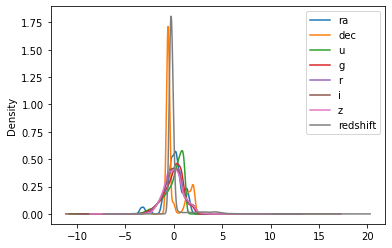

In [180]:
ax1 = scaled_data.drop(columns=[x for x in scaled_data if 'class' in x]).plot.kde()

In [181]:
for x in scaled_data:
	if 'class' in x:
		scaled_data[x].replace({1: 0.9, 0: 0.1}, inplace=True)
scaled_data.head()

,ra,dec,u,g,r,i,z,redshift,class_GALAXY,class_QSO,class_STAR
0,0.167450,-0.584893,1.031435,-0.348542,-0.837238,-0.946010,-0.995292,-0.369713,0.1,0.1,0.9
1,0.168853,-0.583085,0.052428,-0.166524,-0.154148,-0.082640,-0.026042,-0.369831,0.1,0.1,0.9
2,0.170566,-0.583446,0.921522,0.867050,0.593124,0.441179,0.314512,-0.053024,0.9,0.1,0.1
3,0.174549,-0.586471,-1.030579,-0.813587,-0.636660,-0.526578,-0.430900,-0.369974,0.1,0.1,0.9
4,0.174816,-0.584383,-1.290168,-1.172461,-0.376744,-0.025100,0.158269,-0.368171,0.1,0.1,0.9


In [182]:
scaled_data.to_pickle('data/prepared_data.pickle')
scaled_data.to_csv('data/prepared_data.csv')